# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.92KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

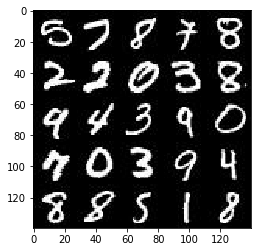

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

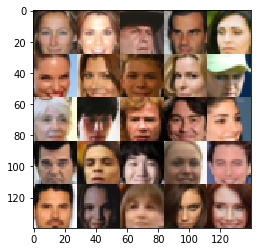

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
                
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width=data_shape[1]
    image_height=data_shape[2]
    channels=data_shape[3]
    input_real, input_z, lr=model_inputs(image_width,image_height,channels, z_dim)
    d_loss, g_loss=model_loss(input_real, input_z, channels)
    d_opt, g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    num=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                num+=1
                batch_images=batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if num % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch: {}/{}     ".format(epoch_i, epoch_count),
                          "Batch: {}     ".format(num),
                          "Discriminator Loss: {:.4f}     ".format(train_loss_d),
                          "Generator Loss: {:.4f}     ".format(train_loss_g))

                if num % 50 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0/2      Batch: 10      Discriminator Loss: 3.8695      Generator Loss: 0.0477     
Epoch: 0/2      Batch: 20      Discriminator Loss: 2.5325      Generator Loss: 0.1151     
Epoch: 0/2      Batch: 30      Discriminator Loss: 2.2282      Generator Loss: 0.1540     
Epoch: 0/2      Batch: 40      Discriminator Loss: 1.9656      Generator Loss: 0.4746     
Epoch: 0/2      Batch: 50      Discriminator Loss: 1.8637      Generator Loss: 0.2378     


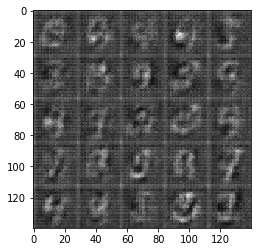

Epoch: 0/2      Batch: 60      Discriminator Loss: 1.5645      Generator Loss: 0.6025     
Epoch: 0/2      Batch: 70      Discriminator Loss: 1.4834      Generator Loss: 0.4030     
Epoch: 0/2      Batch: 80      Discriminator Loss: 1.4929      Generator Loss: 0.3987     
Epoch: 0/2      Batch: 90      Discriminator Loss: 1.3831      Generator Loss: 0.8542     
Epoch: 0/2      Batch: 100      Discriminator Loss: 1.5555      Generator Loss: 0.3331     


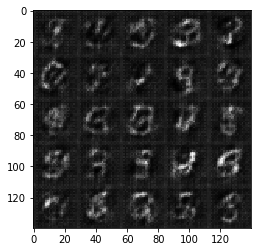

Epoch: 0/2      Batch: 110      Discriminator Loss: 1.5487      Generator Loss: 0.3451     
Epoch: 0/2      Batch: 120      Discriminator Loss: 1.3000      Generator Loss: 0.6304     
Epoch: 0/2      Batch: 130      Discriminator Loss: 1.3314      Generator Loss: 0.5065     
Epoch: 0/2      Batch: 140      Discriminator Loss: 1.5768      Generator Loss: 0.3280     
Epoch: 0/2      Batch: 150      Discriminator Loss: 1.2601      Generator Loss: 0.5933     


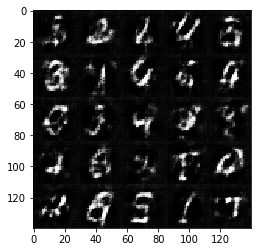

Epoch: 0/2      Batch: 160      Discriminator Loss: 1.3717      Generator Loss: 0.6598     
Epoch: 0/2      Batch: 170      Discriminator Loss: 1.4031      Generator Loss: 0.5955     
Epoch: 0/2      Batch: 180      Discriminator Loss: 1.3946      Generator Loss: 0.4621     
Epoch: 0/2      Batch: 190      Discriminator Loss: 1.8021      Generator Loss: 0.2504     
Epoch: 0/2      Batch: 200      Discriminator Loss: 1.4794      Generator Loss: 1.1381     


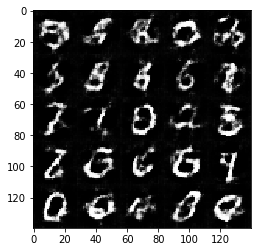

Epoch: 0/2      Batch: 210      Discriminator Loss: 1.3686      Generator Loss: 0.7877     
Epoch: 0/2      Batch: 220      Discriminator Loss: 1.6378      Generator Loss: 0.3101     
Epoch: 0/2      Batch: 230      Discriminator Loss: 1.4661      Generator Loss: 0.4197     
Epoch: 0/2      Batch: 240      Discriminator Loss: 1.2571      Generator Loss: 0.5898     
Epoch: 0/2      Batch: 250      Discriminator Loss: 1.2152      Generator Loss: 1.1025     


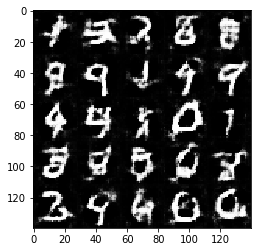

Epoch: 0/2      Batch: 260      Discriminator Loss: 1.3914      Generator Loss: 1.1240     
Epoch: 0/2      Batch: 270      Discriminator Loss: 1.4850      Generator Loss: 0.4022     
Epoch: 0/2      Batch: 280      Discriminator Loss: 1.2131      Generator Loss: 0.6205     
Epoch: 0/2      Batch: 290      Discriminator Loss: 1.4423      Generator Loss: 1.1238     
Epoch: 0/2      Batch: 300      Discriminator Loss: 1.5605      Generator Loss: 0.3106     


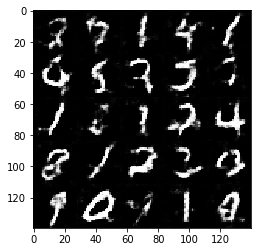

Epoch: 0/2      Batch: 310      Discriminator Loss: 1.7414      Generator Loss: 0.2359     
Epoch: 0/2      Batch: 320      Discriminator Loss: 1.6856      Generator Loss: 0.2660     
Epoch: 0/2      Batch: 330      Discriminator Loss: 1.4733      Generator Loss: 0.3908     
Epoch: 0/2      Batch: 340      Discriminator Loss: 1.4676      Generator Loss: 0.4439     
Epoch: 0/2      Batch: 350      Discriminator Loss: 1.4721      Generator Loss: 0.3610     


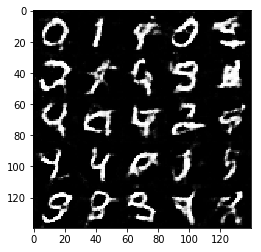

Epoch: 0/2      Batch: 360      Discriminator Loss: 1.2287      Generator Loss: 0.5564     
Epoch: 0/2      Batch: 370      Discriminator Loss: 1.2613      Generator Loss: 0.6604     
Epoch: 0/2      Batch: 380      Discriminator Loss: 1.2955      Generator Loss: 0.6305     
Epoch: 0/2      Batch: 390      Discriminator Loss: 1.6758      Generator Loss: 0.2891     
Epoch: 0/2      Batch: 400      Discriminator Loss: 1.2288      Generator Loss: 0.5992     


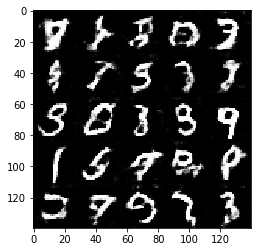

Epoch: 0/2      Batch: 410      Discriminator Loss: 1.3860      Generator Loss: 0.3813     
Epoch: 0/2      Batch: 420      Discriminator Loss: 1.2368      Generator Loss: 0.5550     
Epoch: 0/2      Batch: 430      Discriminator Loss: 1.4212      Generator Loss: 0.5200     
Epoch: 0/2      Batch: 440      Discriminator Loss: 1.1854      Generator Loss: 0.9127     
Epoch: 0/2      Batch: 450      Discriminator Loss: 1.3120      Generator Loss: 0.5478     


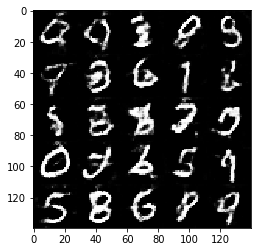

Epoch: 0/2      Batch: 460      Discriminator Loss: 1.7322      Generator Loss: 0.2655     
Epoch: 0/2      Batch: 470      Discriminator Loss: 1.1635      Generator Loss: 0.5833     
Epoch: 0/2      Batch: 480      Discriminator Loss: 2.6670      Generator Loss: 2.7197     
Epoch: 0/2      Batch: 490      Discriminator Loss: 1.5262      Generator Loss: 0.3627     
Epoch: 0/2      Batch: 500      Discriminator Loss: 1.4504      Generator Loss: 0.4059     


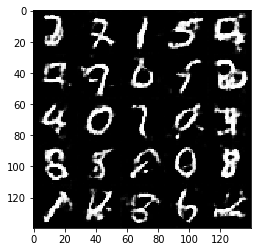

Epoch: 0/2      Batch: 510      Discriminator Loss: 1.3284      Generator Loss: 0.4781     
Epoch: 0/2      Batch: 520      Discriminator Loss: 1.3410      Generator Loss: 0.4993     
Epoch: 0/2      Batch: 530      Discriminator Loss: 1.6820      Generator Loss: 0.2931     
Epoch: 0/2      Batch: 540      Discriminator Loss: 1.3693      Generator Loss: 0.8196     
Epoch: 0/2      Batch: 550      Discriminator Loss: 1.8414      Generator Loss: 0.2393     


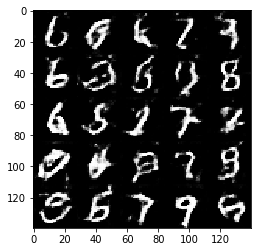

Epoch: 0/2      Batch: 560      Discriminator Loss: 1.5782      Generator Loss: 0.3110     
Epoch: 0/2      Batch: 570      Discriminator Loss: 1.1856      Generator Loss: 0.6641     
Epoch: 0/2      Batch: 580      Discriminator Loss: 1.5230      Generator Loss: 0.4492     
Epoch: 0/2      Batch: 590      Discriminator Loss: 1.0957      Generator Loss: 0.6744     
Epoch: 0/2      Batch: 600      Discriminator Loss: 1.7990      Generator Loss: 0.2491     


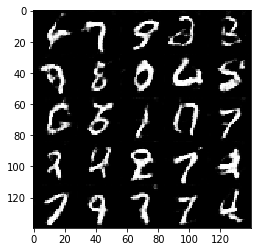

Epoch: 0/2      Batch: 610      Discriminator Loss: 1.9892      Generator Loss: 0.1841     
Epoch: 0/2      Batch: 620      Discriminator Loss: 1.2504      Generator Loss: 0.5480     
Epoch: 0/2      Batch: 630      Discriminator Loss: 1.7275      Generator Loss: 0.2576     
Epoch: 0/2      Batch: 640      Discriminator Loss: 1.4130      Generator Loss: 0.3984     
Epoch: 0/2      Batch: 650      Discriminator Loss: 2.0555      Generator Loss: 1.7262     


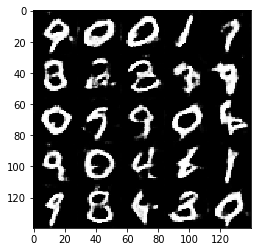

Epoch: 0/2      Batch: 660      Discriminator Loss: 1.4112      Generator Loss: 0.4582     
Epoch: 0/2      Batch: 670      Discriminator Loss: 1.1877      Generator Loss: 0.6368     
Epoch: 0/2      Batch: 680      Discriminator Loss: 1.4510      Generator Loss: 0.4176     
Epoch: 0/2      Batch: 690      Discriminator Loss: 2.1961      Generator Loss: 0.1492     
Epoch: 0/2      Batch: 700      Discriminator Loss: 1.4003      Generator Loss: 0.4264     


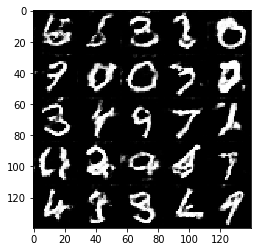

Epoch: 0/2      Batch: 710      Discriminator Loss: 1.5788      Generator Loss: 0.3226     
Epoch: 0/2      Batch: 720      Discriminator Loss: 1.4095      Generator Loss: 0.3918     
Epoch: 0/2      Batch: 730      Discriminator Loss: 1.9343      Generator Loss: 0.2134     
Epoch: 0/2      Batch: 740      Discriminator Loss: 1.4487      Generator Loss: 0.3807     
Epoch: 0/2      Batch: 750      Discriminator Loss: 2.5755      Generator Loss: 0.1068     


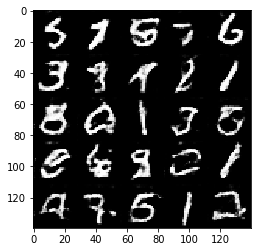

Epoch: 0/2      Batch: 760      Discriminator Loss: 1.4179      Generator Loss: 0.5234     
Epoch: 0/2      Batch: 770      Discriminator Loss: 1.2966      Generator Loss: 0.5421     
Epoch: 0/2      Batch: 780      Discriminator Loss: 1.2470      Generator Loss: 1.3323     
Epoch: 0/2      Batch: 790      Discriminator Loss: 1.3513      Generator Loss: 0.5586     
Epoch: 0/2      Batch: 800      Discriminator Loss: 1.1480      Generator Loss: 1.2206     


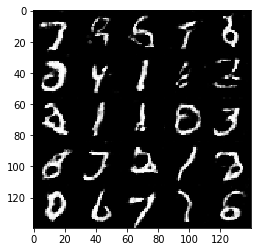

Epoch: 0/2      Batch: 810      Discriminator Loss: 1.1835      Generator Loss: 0.9818     
Epoch: 0/2      Batch: 820      Discriminator Loss: 1.3881      Generator Loss: 0.4347     
Epoch: 0/2      Batch: 830      Discriminator Loss: 1.4339      Generator Loss: 0.4102     
Epoch: 0/2      Batch: 840      Discriminator Loss: 1.2152      Generator Loss: 0.4972     
Epoch: 0/2      Batch: 850      Discriminator Loss: 0.9989      Generator Loss: 0.9766     


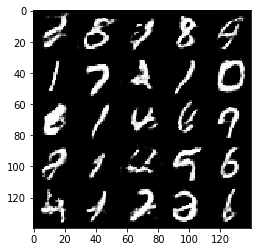

Epoch: 0/2      Batch: 860      Discriminator Loss: 1.1401      Generator Loss: 0.7549     
Epoch: 0/2      Batch: 870      Discriminator Loss: 1.1514      Generator Loss: 1.2285     
Epoch: 0/2      Batch: 880      Discriminator Loss: 1.3794      Generator Loss: 0.3967     
Epoch: 0/2      Batch: 890      Discriminator Loss: 1.5154      Generator Loss: 0.3664     
Epoch: 0/2      Batch: 900      Discriminator Loss: 1.3708      Generator Loss: 0.4104     


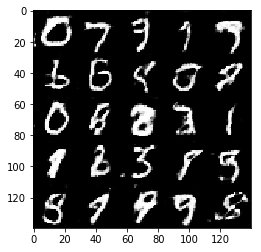

Epoch: 0/2      Batch: 910      Discriminator Loss: 2.9944      Generator Loss: 0.1109     
Epoch: 0/2      Batch: 920      Discriminator Loss: 1.1278      Generator Loss: 0.8087     
Epoch: 0/2      Batch: 930      Discriminator Loss: 1.1858      Generator Loss: 0.8459     
Epoch: 1/2      Batch: 940      Discriminator Loss: 1.3167      Generator Loss: 0.5714     
Epoch: 1/2      Batch: 950      Discriminator Loss: 1.2904      Generator Loss: 0.7407     


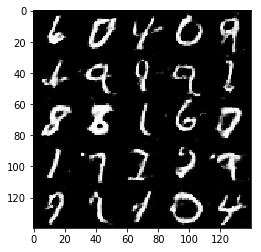

Epoch: 1/2      Batch: 960      Discriminator Loss: 1.8900      Generator Loss: 0.2089     
Epoch: 1/2      Batch: 970      Discriminator Loss: 1.5298      Generator Loss: 0.3888     
Epoch: 1/2      Batch: 980      Discriminator Loss: 1.4260      Generator Loss: 0.4373     
Epoch: 1/2      Batch: 990      Discriminator Loss: 1.2120      Generator Loss: 0.6724     
Epoch: 1/2      Batch: 1000      Discriminator Loss: 1.3111      Generator Loss: 0.5398     


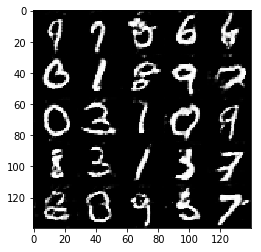

Epoch: 1/2      Batch: 1010      Discriminator Loss: 1.1007      Generator Loss: 0.7584     
Epoch: 1/2      Batch: 1020      Discriminator Loss: 2.1896      Generator Loss: 0.1881     
Epoch: 1/2      Batch: 1030      Discriminator Loss: 1.9215      Generator Loss: 0.3012     
Epoch: 1/2      Batch: 1040      Discriminator Loss: 1.3007      Generator Loss: 1.4851     
Epoch: 1/2      Batch: 1050      Discriminator Loss: 1.3283      Generator Loss: 0.4366     


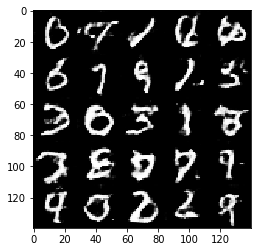

Epoch: 1/2      Batch: 1060      Discriminator Loss: 1.4477      Generator Loss: 0.3915     
Epoch: 1/2      Batch: 1070      Discriminator Loss: 1.3476      Generator Loss: 0.5517     
Epoch: 1/2      Batch: 1080      Discriminator Loss: 1.3689      Generator Loss: 0.4652     
Epoch: 1/2      Batch: 1090      Discriminator Loss: 1.6693      Generator Loss: 0.3328     
Epoch: 1/2      Batch: 1100      Discriminator Loss: 1.2406      Generator Loss: 0.5115     


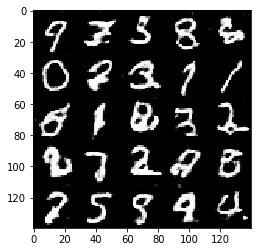

Epoch: 1/2      Batch: 1110      Discriminator Loss: 1.4958      Generator Loss: 0.3665     
Epoch: 1/2      Batch: 1120      Discriminator Loss: 1.3808      Generator Loss: 0.4363     
Epoch: 1/2      Batch: 1130      Discriminator Loss: 2.0355      Generator Loss: 0.2010     
Epoch: 1/2      Batch: 1140      Discriminator Loss: 1.1381      Generator Loss: 0.6917     
Epoch: 1/2      Batch: 1150      Discriminator Loss: 1.2206      Generator Loss: 0.7213     


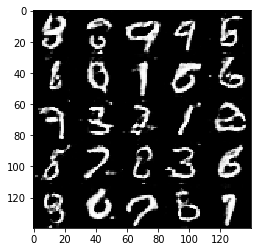

Epoch: 1/2      Batch: 1160      Discriminator Loss: 1.1783      Generator Loss: 0.9498     
Epoch: 1/2      Batch: 1170      Discriminator Loss: 1.9356      Generator Loss: 0.2302     
Epoch: 1/2      Batch: 1180      Discriminator Loss: 2.0114      Generator Loss: 0.2076     
Epoch: 1/2      Batch: 1190      Discriminator Loss: 1.5575      Generator Loss: 0.4004     
Epoch: 1/2      Batch: 1200      Discriminator Loss: 1.0478      Generator Loss: 0.8837     


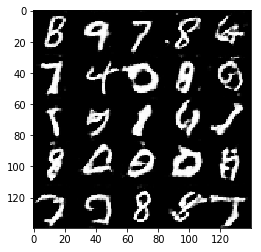

Epoch: 1/2      Batch: 1210      Discriminator Loss: 1.3314      Generator Loss: 0.4708     
Epoch: 1/2      Batch: 1220      Discriminator Loss: 1.4636      Generator Loss: 0.3846     
Epoch: 1/2      Batch: 1230      Discriminator Loss: 1.6377      Generator Loss: 0.3383     
Epoch: 1/2      Batch: 1240      Discriminator Loss: 1.7288      Generator Loss: 0.2721     
Epoch: 1/2      Batch: 1250      Discriminator Loss: 1.3929      Generator Loss: 0.3896     


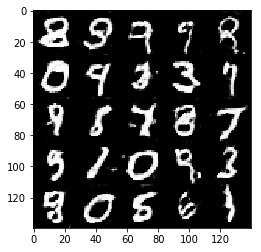

Epoch: 1/2      Batch: 1260      Discriminator Loss: 1.2843      Generator Loss: 0.6084     
Epoch: 1/2      Batch: 1270      Discriminator Loss: 1.5885      Generator Loss: 0.3396     
Epoch: 1/2      Batch: 1280      Discriminator Loss: 1.2776      Generator Loss: 0.5429     
Epoch: 1/2      Batch: 1290      Discriminator Loss: 1.2696      Generator Loss: 0.5067     
Epoch: 1/2      Batch: 1300      Discriminator Loss: 1.3415      Generator Loss: 0.4657     


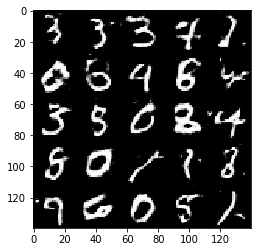

Epoch: 1/2      Batch: 1310      Discriminator Loss: 2.2316      Generator Loss: 0.1671     
Epoch: 1/2      Batch: 1320      Discriminator Loss: 1.8147      Generator Loss: 0.2899     
Epoch: 1/2      Batch: 1330      Discriminator Loss: 1.5899      Generator Loss: 0.3627     
Epoch: 1/2      Batch: 1340      Discriminator Loss: 1.0531      Generator Loss: 0.6476     
Epoch: 1/2      Batch: 1350      Discriminator Loss: 1.4937      Generator Loss: 0.4412     


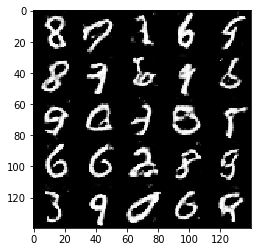

Epoch: 1/2      Batch: 1360      Discriminator Loss: 1.0723      Generator Loss: 0.7799     
Epoch: 1/2      Batch: 1370      Discriminator Loss: 2.4596      Generator Loss: 0.1381     
Epoch: 1/2      Batch: 1380      Discriminator Loss: 1.2331      Generator Loss: 0.5144     
Epoch: 1/2      Batch: 1390      Discriminator Loss: 0.8365      Generator Loss: 0.8100     
Epoch: 1/2      Batch: 1400      Discriminator Loss: 1.3915      Generator Loss: 0.4694     


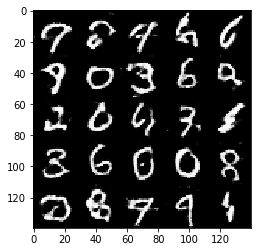

Epoch: 1/2      Batch: 1410      Discriminator Loss: 1.4875      Generator Loss: 0.3788     
Epoch: 1/2      Batch: 1420      Discriminator Loss: 1.0482      Generator Loss: 0.9882     
Epoch: 1/2      Batch: 1430      Discriminator Loss: 1.5768      Generator Loss: 2.1540     
Epoch: 1/2      Batch: 1440      Discriminator Loss: 1.2070      Generator Loss: 0.5791     
Epoch: 1/2      Batch: 1450      Discriminator Loss: 1.7049      Generator Loss: 0.2921     


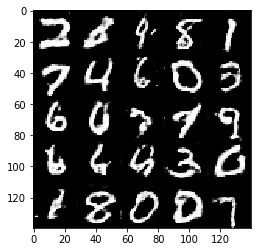

Epoch: 1/2      Batch: 1460      Discriminator Loss: 1.3420      Generator Loss: 0.4278     
Epoch: 1/2      Batch: 1470      Discriminator Loss: 1.6846      Generator Loss: 0.3223     
Epoch: 1/2      Batch: 1480      Discriminator Loss: 2.1391      Generator Loss: 0.2161     
Epoch: 1/2      Batch: 1490      Discriminator Loss: 2.7773      Generator Loss: 3.5248     
Epoch: 1/2      Batch: 1500      Discriminator Loss: 1.2892      Generator Loss: 0.5715     


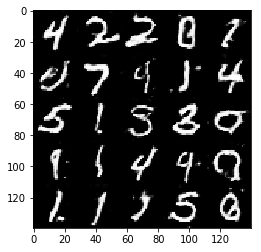

Epoch: 1/2      Batch: 1510      Discriminator Loss: 1.7236      Generator Loss: 0.3465     
Epoch: 1/2      Batch: 1520      Discriminator Loss: 1.3920      Generator Loss: 0.4181     
Epoch: 1/2      Batch: 1530      Discriminator Loss: 0.8137      Generator Loss: 1.0257     
Epoch: 1/2      Batch: 1540      Discriminator Loss: 1.5709      Generator Loss: 0.3282     
Epoch: 1/2      Batch: 1550      Discriminator Loss: 1.3813      Generator Loss: 0.4815     


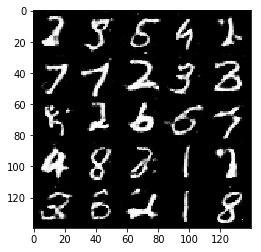

Epoch: 1/2      Batch: 1560      Discriminator Loss: 1.9051      Generator Loss: 0.2427     
Epoch: 1/2      Batch: 1570      Discriminator Loss: 1.7385      Generator Loss: 0.3126     
Epoch: 1/2      Batch: 1580      Discriminator Loss: 1.7096      Generator Loss: 3.3818     
Epoch: 1/2      Batch: 1590      Discriminator Loss: 1.0910      Generator Loss: 0.6148     
Epoch: 1/2      Batch: 1600      Discriminator Loss: 1.1641      Generator Loss: 0.5938     


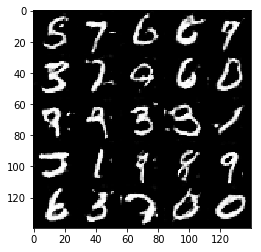

Epoch: 1/2      Batch: 1610      Discriminator Loss: 1.0581      Generator Loss: 0.6057     
Epoch: 1/2      Batch: 1620      Discriminator Loss: 1.7061      Generator Loss: 0.3019     
Epoch: 1/2      Batch: 1630      Discriminator Loss: 1.8623      Generator Loss: 0.2786     
Epoch: 1/2      Batch: 1640      Discriminator Loss: 1.0770      Generator Loss: 0.6302     
Epoch: 1/2      Batch: 1650      Discriminator Loss: 1.5258      Generator Loss: 0.4245     


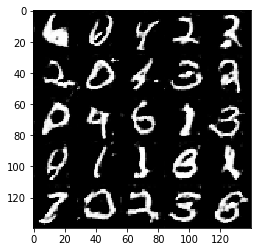

Epoch: 1/2      Batch: 1660      Discriminator Loss: 1.9413      Generator Loss: 0.2701     
Epoch: 1/2      Batch: 1670      Discriminator Loss: 2.1837      Generator Loss: 3.3916     
Epoch: 1/2      Batch: 1680      Discriminator Loss: 1.8317      Generator Loss: 0.2636     
Epoch: 1/2      Batch: 1690      Discriminator Loss: 1.4799      Generator Loss: 0.3533     
Epoch: 1/2      Batch: 1700      Discriminator Loss: 1.2056      Generator Loss: 0.4947     


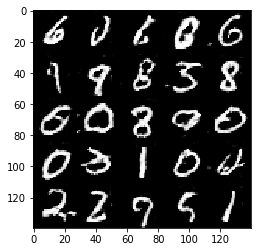

Epoch: 1/2      Batch: 1710      Discriminator Loss: 1.3731      Generator Loss: 0.4418     
Epoch: 1/2      Batch: 1720      Discriminator Loss: 1.1977      Generator Loss: 0.5629     
Epoch: 1/2      Batch: 1730      Discriminator Loss: 0.8548      Generator Loss: 1.2135     
Epoch: 1/2      Batch: 1740      Discriminator Loss: 0.9781      Generator Loss: 0.9903     
Epoch: 1/2      Batch: 1750      Discriminator Loss: 1.5499      Generator Loss: 0.3245     


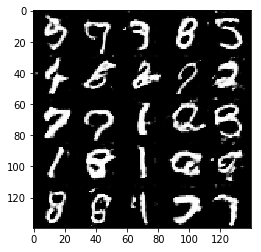

Epoch: 1/2      Batch: 1760      Discriminator Loss: 1.8075      Generator Loss: 0.3253     
Epoch: 1/2      Batch: 1770      Discriminator Loss: 1.1931      Generator Loss: 0.5644     
Epoch: 1/2      Batch: 1780      Discriminator Loss: 1.2576      Generator Loss: 0.5386     
Epoch: 1/2      Batch: 1790      Discriminator Loss: 1.4899      Generator Loss: 0.3837     
Epoch: 1/2      Batch: 1800      Discriminator Loss: 1.6244      Generator Loss: 0.3307     


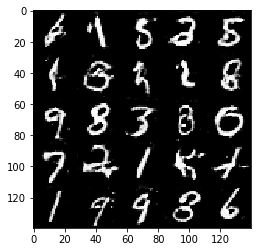

Epoch: 1/2      Batch: 1810      Discriminator Loss: 1.5800      Generator Loss: 0.3872     
Epoch: 1/2      Batch: 1820      Discriminator Loss: 1.1762      Generator Loss: 0.6353     
Epoch: 1/2      Batch: 1830      Discriminator Loss: 1.6608      Generator Loss: 0.3348     
Epoch: 1/2      Batch: 1840      Discriminator Loss: 1.6588      Generator Loss: 0.3758     
Epoch: 1/2      Batch: 1850      Discriminator Loss: 1.7199      Generator Loss: 0.3774     


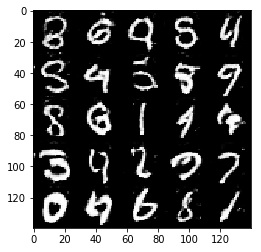

Epoch: 1/2      Batch: 1860      Discriminator Loss: 1.2777      Generator Loss: 0.5526     
Epoch: 1/2      Batch: 1870      Discriminator Loss: 1.2382      Generator Loss: 0.6981     


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0/1      Batch: 10      Discriminator Loss: 4.1437      Generator Loss: 0.0250     
Epoch: 0/1      Batch: 20      Discriminator Loss: 3.1977      Generator Loss: 0.0840     
Epoch: 0/1      Batch: 30      Discriminator Loss: 2.1474      Generator Loss: 0.1805     
Epoch: 0/1      Batch: 40      Discriminator Loss: 2.3237      Generator Loss: 0.2417     
Epoch: 0/1      Batch: 50      Discriminator Loss: 1.8612      Generator Loss: 0.5118     


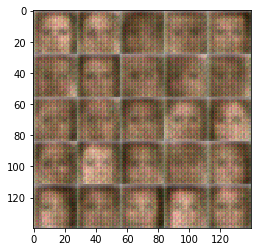

Epoch: 0/1      Batch: 60      Discriminator Loss: 1.7357      Generator Loss: 0.4785     
Epoch: 0/1      Batch: 70      Discriminator Loss: 1.5167      Generator Loss: 0.5400     
Epoch: 0/1      Batch: 80      Discriminator Loss: 2.3376      Generator Loss: 0.1828     
Epoch: 0/1      Batch: 90      Discriminator Loss: 1.6604      Generator Loss: 0.5793     
Epoch: 0/1      Batch: 100      Discriminator Loss: 1.6305      Generator Loss: 0.3177     


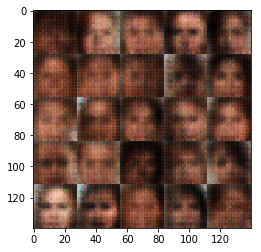

Epoch: 0/1      Batch: 110      Discriminator Loss: 1.4265      Generator Loss: 0.5204     
Epoch: 0/1      Batch: 120      Discriminator Loss: 1.5109      Generator Loss: 1.1190     
Epoch: 0/1      Batch: 130      Discriminator Loss: 1.4136      Generator Loss: 0.6520     
Epoch: 0/1      Batch: 140      Discriminator Loss: 1.7982      Generator Loss: 0.2692     
Epoch: 0/1      Batch: 150      Discriminator Loss: 2.0972      Generator Loss: 0.2284     


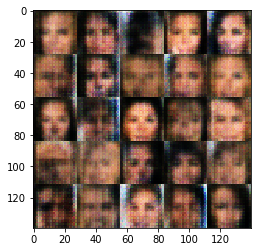

Epoch: 0/1      Batch: 160      Discriminator Loss: 1.3422      Generator Loss: 0.8237     
Epoch: 0/1      Batch: 170      Discriminator Loss: 1.3458      Generator Loss: 1.2975     
Epoch: 0/1      Batch: 180      Discriminator Loss: 0.7778      Generator Loss: 2.6443     
Epoch: 0/1      Batch: 190      Discriminator Loss: 1.3760      Generator Loss: 1.1227     
Epoch: 0/1      Batch: 200      Discriminator Loss: 1.5878      Generator Loss: 0.4159     


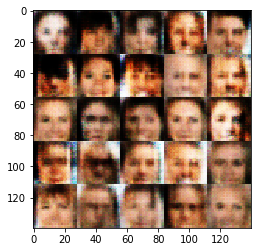

Epoch: 0/1      Batch: 210      Discriminator Loss: 1.0971      Generator Loss: 1.4094     
Epoch: 0/1      Batch: 220      Discriminator Loss: 1.9462      Generator Loss: 0.2316     
Epoch: 0/1      Batch: 230      Discriminator Loss: 1.1647      Generator Loss: 1.2480     
Epoch: 0/1      Batch: 240      Discriminator Loss: 1.6828      Generator Loss: 0.3353     
Epoch: 0/1      Batch: 250      Discriminator Loss: 1.4342      Generator Loss: 0.7915     


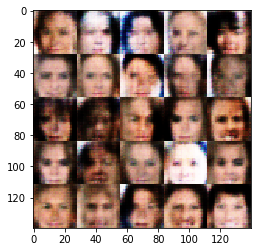

Epoch: 0/1      Batch: 260      Discriminator Loss: 1.6335      Generator Loss: 1.0872     
Epoch: 0/1      Batch: 270      Discriminator Loss: 1.3774      Generator Loss: 0.3955     
Epoch: 0/1      Batch: 280      Discriminator Loss: 1.3827      Generator Loss: 0.5781     
Epoch: 0/1      Batch: 290      Discriminator Loss: 1.5867      Generator Loss: 0.4863     
Epoch: 0/1      Batch: 300      Discriminator Loss: 1.6224      Generator Loss: 0.6961     


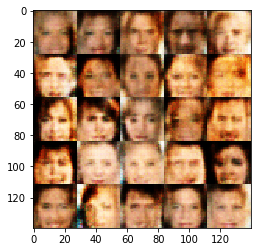

Epoch: 0/1      Batch: 310      Discriminator Loss: 1.1140      Generator Loss: 0.8815     
Epoch: 0/1      Batch: 320      Discriminator Loss: 1.5935      Generator Loss: 0.3810     
Epoch: 0/1      Batch: 330      Discriminator Loss: 1.4125      Generator Loss: 0.4496     
Epoch: 0/1      Batch: 340      Discriminator Loss: 1.3697      Generator Loss: 0.4581     
Epoch: 0/1      Batch: 350      Discriminator Loss: 0.9087      Generator Loss: 1.7525     


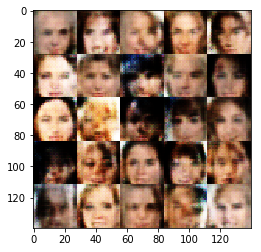

Epoch: 0/1      Batch: 360      Discriminator Loss: 0.7102      Generator Loss: 1.0814     
Epoch: 0/1      Batch: 370      Discriminator Loss: 1.5442      Generator Loss: 0.6560     
Epoch: 0/1      Batch: 380      Discriminator Loss: 1.3524      Generator Loss: 0.7994     
Epoch: 0/1      Batch: 390      Discriminator Loss: 1.6366      Generator Loss: 0.5289     
Epoch: 0/1      Batch: 400      Discriminator Loss: 1.4479      Generator Loss: 0.6842     


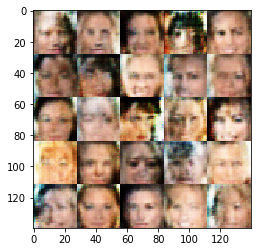

Epoch: 0/1      Batch: 410      Discriminator Loss: 1.3446      Generator Loss: 0.4983     
Epoch: 0/1      Batch: 420      Discriminator Loss: 0.8423      Generator Loss: 0.8143     
Epoch: 0/1      Batch: 430      Discriminator Loss: 1.5990      Generator Loss: 0.4923     
Epoch: 0/1      Batch: 440      Discriminator Loss: 1.3621      Generator Loss: 0.5042     
Epoch: 0/1      Batch: 450      Discriminator Loss: 1.3440      Generator Loss: 0.8155     


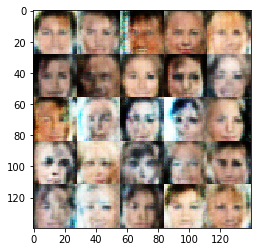

Epoch: 0/1      Batch: 460      Discriminator Loss: 1.3920      Generator Loss: 1.7717     
Epoch: 0/1      Batch: 470      Discriminator Loss: 1.5961      Generator Loss: 0.4945     
Epoch: 0/1      Batch: 480      Discriminator Loss: 1.8035      Generator Loss: 0.3277     
Epoch: 0/1      Batch: 490      Discriminator Loss: 1.5141      Generator Loss: 0.6411     
Epoch: 0/1      Batch: 500      Discriminator Loss: 1.4072      Generator Loss: 0.4027     


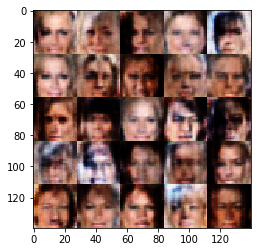

Epoch: 0/1      Batch: 510      Discriminator Loss: 1.4099      Generator Loss: 0.6542     
Epoch: 0/1      Batch: 520      Discriminator Loss: 1.6111      Generator Loss: 0.4864     
Epoch: 0/1      Batch: 530      Discriminator Loss: 1.2495      Generator Loss: 0.5989     
Epoch: 0/1      Batch: 540      Discriminator Loss: 1.5454      Generator Loss: 0.6541     
Epoch: 0/1      Batch: 550      Discriminator Loss: 1.6080      Generator Loss: 0.3909     


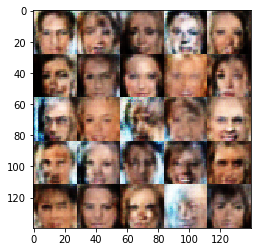

Epoch: 0/1      Batch: 560      Discriminator Loss: 1.5333      Generator Loss: 0.4574     
Epoch: 0/1      Batch: 570      Discriminator Loss: 1.4924      Generator Loss: 0.4888     
Epoch: 0/1      Batch: 580      Discriminator Loss: 1.1634      Generator Loss: 0.5124     
Epoch: 0/1      Batch: 590      Discriminator Loss: 1.5331      Generator Loss: 0.4452     
Epoch: 0/1      Batch: 600      Discriminator Loss: 1.4794      Generator Loss: 0.5167     


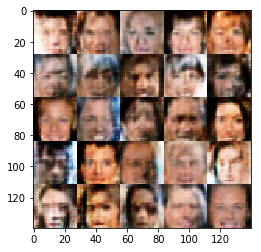

Epoch: 0/1      Batch: 610      Discriminator Loss: 1.2583      Generator Loss: 0.6475     
Epoch: 0/1      Batch: 620      Discriminator Loss: 1.4029      Generator Loss: 0.6055     
Epoch: 0/1      Batch: 630      Discriminator Loss: 1.4312      Generator Loss: 0.5369     
Epoch: 0/1      Batch: 640      Discriminator Loss: 1.5166      Generator Loss: 2.2294     
Epoch: 0/1      Batch: 650      Discriminator Loss: 1.5617      Generator Loss: 0.5260     


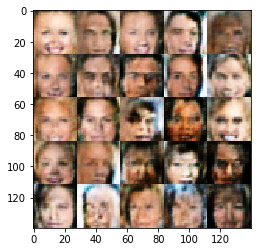

Epoch: 0/1      Batch: 660      Discriminator Loss: 1.5151      Generator Loss: 0.5751     
Epoch: 0/1      Batch: 670      Discriminator Loss: 1.5871      Generator Loss: 0.5151     
Epoch: 0/1      Batch: 680      Discriminator Loss: 1.3653      Generator Loss: 0.5910     
Epoch: 0/1      Batch: 690      Discriminator Loss: 1.4428      Generator Loss: 0.4964     
Epoch: 0/1      Batch: 700      Discriminator Loss: 1.6639      Generator Loss: 1.6289     


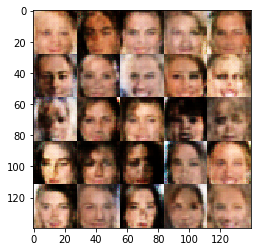

Epoch: 0/1      Batch: 710      Discriminator Loss: 1.4713      Generator Loss: 0.5257     
Epoch: 0/1      Batch: 720      Discriminator Loss: 1.8145      Generator Loss: 0.2614     
Epoch: 0/1      Batch: 730      Discriminator Loss: 1.5059      Generator Loss: 0.4435     
Epoch: 0/1      Batch: 740      Discriminator Loss: 1.5227      Generator Loss: 0.4159     
Epoch: 0/1      Batch: 750      Discriminator Loss: 1.5039      Generator Loss: 0.5168     


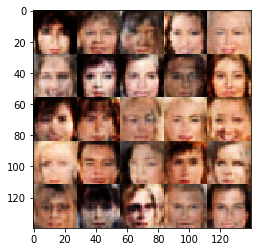

Epoch: 0/1      Batch: 760      Discriminator Loss: 1.3956      Generator Loss: 0.4617     
Epoch: 0/1      Batch: 770      Discriminator Loss: 1.3292      Generator Loss: 0.5868     
Epoch: 0/1      Batch: 780      Discriminator Loss: 1.5017      Generator Loss: 0.9651     
Epoch: 0/1      Batch: 790      Discriminator Loss: 1.4758      Generator Loss: 0.9184     
Epoch: 0/1      Batch: 800      Discriminator Loss: 1.5527      Generator Loss: 1.0950     


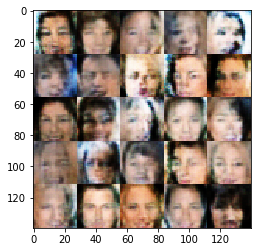

Epoch: 0/1      Batch: 810      Discriminator Loss: 1.6133      Generator Loss: 0.4474     
Epoch: 0/1      Batch: 820      Discriminator Loss: 1.5817      Generator Loss: 0.5614     
Epoch: 0/1      Batch: 830      Discriminator Loss: 1.4786      Generator Loss: 0.4328     
Epoch: 0/1      Batch: 840      Discriminator Loss: 1.4748      Generator Loss: 0.8827     
Epoch: 0/1      Batch: 850      Discriminator Loss: 1.0903      Generator Loss: 0.6185     


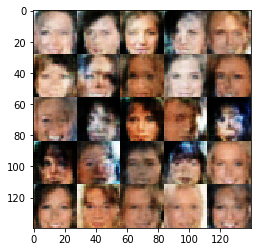

Epoch: 0/1      Batch: 860      Discriminator Loss: 1.2254      Generator Loss: 0.8465     
Epoch: 0/1      Batch: 870      Discriminator Loss: 1.2865      Generator Loss: 0.6408     
Epoch: 0/1      Batch: 880      Discriminator Loss: 1.3288      Generator Loss: 0.8112     
Epoch: 0/1      Batch: 890      Discriminator Loss: 1.4229      Generator Loss: 0.5246     
Epoch: 0/1      Batch: 900      Discriminator Loss: 1.5652      Generator Loss: 0.3734     


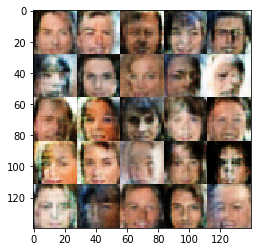

Epoch: 0/1      Batch: 910      Discriminator Loss: 1.5387      Generator Loss: 0.3964     
Epoch: 0/1      Batch: 920      Discriminator Loss: 1.1963      Generator Loss: 0.8649     
Epoch: 0/1      Batch: 930      Discriminator Loss: 1.1291      Generator Loss: 2.1999     
Epoch: 0/1      Batch: 940      Discriminator Loss: 1.4996      Generator Loss: 0.6758     
Epoch: 0/1      Batch: 950      Discriminator Loss: 1.5465      Generator Loss: 0.3583     


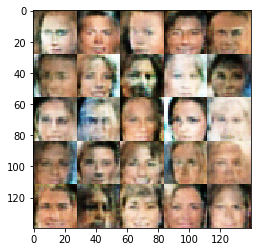

Epoch: 0/1      Batch: 960      Discriminator Loss: 1.4311      Generator Loss: 0.8351     
Epoch: 0/1      Batch: 970      Discriminator Loss: 1.3484      Generator Loss: 0.6434     
Epoch: 0/1      Batch: 980      Discriminator Loss: 1.5888      Generator Loss: 0.3271     
Epoch: 0/1      Batch: 990      Discriminator Loss: 1.2914      Generator Loss: 0.5470     
Epoch: 0/1      Batch: 1000      Discriminator Loss: 1.4037      Generator Loss: 0.5796     


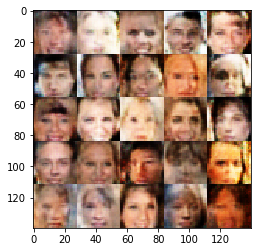

Epoch: 0/1      Batch: 1010      Discriminator Loss: 1.8766      Generator Loss: 0.2246     
Epoch: 0/1      Batch: 1020      Discriminator Loss: 1.5940      Generator Loss: 0.4883     
Epoch: 0/1      Batch: 1030      Discriminator Loss: 1.4030      Generator Loss: 0.5480     
Epoch: 0/1      Batch: 1040      Discriminator Loss: 1.4588      Generator Loss: 0.5523     
Epoch: 0/1      Batch: 1050      Discriminator Loss: 1.6647      Generator Loss: 0.3314     


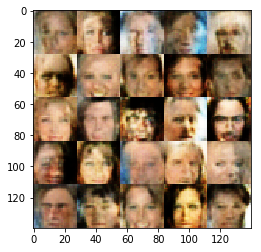

Epoch: 0/1      Batch: 1060      Discriminator Loss: 1.6446      Generator Loss: 0.3159     
Epoch: 0/1      Batch: 1070      Discriminator Loss: 1.3064      Generator Loss: 0.5775     
Epoch: 0/1      Batch: 1080      Discriminator Loss: 1.5420      Generator Loss: 0.3980     
Epoch: 0/1      Batch: 1090      Discriminator Loss: 1.7727      Generator Loss: 0.2745     
Epoch: 0/1      Batch: 1100      Discriminator Loss: 1.4363      Generator Loss: 0.5531     


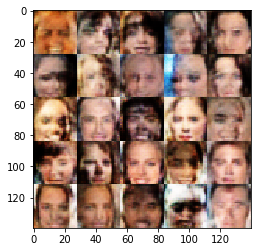

Epoch: 0/1      Batch: 1110      Discriminator Loss: 1.4582      Generator Loss: 0.6288     
Epoch: 0/1      Batch: 1120      Discriminator Loss: 1.5064      Generator Loss: 0.4771     
Epoch: 0/1      Batch: 1130      Discriminator Loss: 1.3363      Generator Loss: 0.7787     
Epoch: 0/1      Batch: 1140      Discriminator Loss: 1.4941      Generator Loss: 0.3868     
Epoch: 0/1      Batch: 1150      Discriminator Loss: 1.3998      Generator Loss: 0.3916     


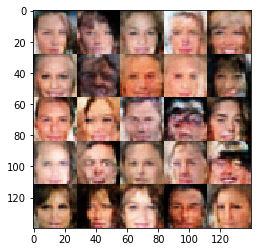

Epoch: 0/1      Batch: 1160      Discriminator Loss: 1.6591      Generator Loss: 0.3343     
Epoch: 0/1      Batch: 1170      Discriminator Loss: 1.3073      Generator Loss: 0.7306     
Epoch: 0/1      Batch: 1180      Discriminator Loss: 1.9869      Generator Loss: 0.2292     
Epoch: 0/1      Batch: 1190      Discriminator Loss: 1.3867      Generator Loss: 0.8678     
Epoch: 0/1      Batch: 1200      Discriminator Loss: 1.3808      Generator Loss: 0.6881     


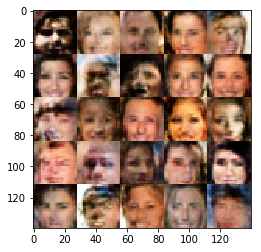

Epoch: 0/1      Batch: 1210      Discriminator Loss: 1.4379      Generator Loss: 0.4371     
Epoch: 0/1      Batch: 1220      Discriminator Loss: 1.4912      Generator Loss: 0.5053     
Epoch: 0/1      Batch: 1230      Discriminator Loss: 1.4631      Generator Loss: 0.3642     
Epoch: 0/1      Batch: 1240      Discriminator Loss: 1.8405      Generator Loss: 0.5856     
Epoch: 0/1      Batch: 1250      Discriminator Loss: 1.6217      Generator Loss: 0.3459     


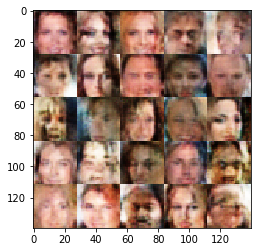

Epoch: 0/1      Batch: 1260      Discriminator Loss: 1.4991      Generator Loss: 0.3650     
Epoch: 0/1      Batch: 1270      Discriminator Loss: 1.3533      Generator Loss: 0.4439     
Epoch: 0/1      Batch: 1280      Discriminator Loss: 1.5593      Generator Loss: 0.5472     
Epoch: 0/1      Batch: 1290      Discriminator Loss: 1.2373      Generator Loss: 0.5913     
Epoch: 0/1      Batch: 1300      Discriminator Loss: 1.4534      Generator Loss: 0.4323     


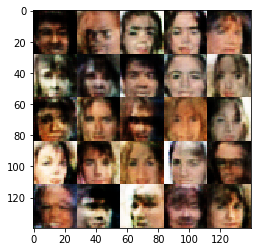

Epoch: 0/1      Batch: 1310      Discriminator Loss: 1.5760      Generator Loss: 0.4562     
Epoch: 0/1      Batch: 1320      Discriminator Loss: 1.6004      Generator Loss: 0.5032     
Epoch: 0/1      Batch: 1330      Discriminator Loss: 1.5273      Generator Loss: 0.6569     
Epoch: 0/1      Batch: 1340      Discriminator Loss: 1.5361      Generator Loss: 0.5308     
Epoch: 0/1      Batch: 1350      Discriminator Loss: 1.2944      Generator Loss: 1.1430     


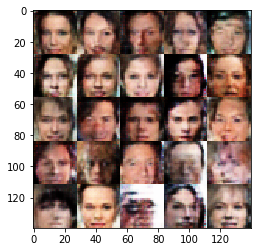

Epoch: 0/1      Batch: 1360      Discriminator Loss: 1.2767      Generator Loss: 0.7059     
Epoch: 0/1      Batch: 1370      Discriminator Loss: 1.5661      Generator Loss: 0.4111     
Epoch: 0/1      Batch: 1380      Discriminator Loss: 1.3118      Generator Loss: 0.7468     
Epoch: 0/1      Batch: 1390      Discriminator Loss: 1.7553      Generator Loss: 0.4487     
Epoch: 0/1      Batch: 1400      Discriminator Loss: 1.6569      Generator Loss: 0.4584     


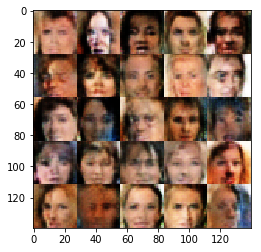

Epoch: 0/1      Batch: 1410      Discriminator Loss: 1.8270      Generator Loss: 0.4728     
Epoch: 0/1      Batch: 1420      Discriminator Loss: 1.4239      Generator Loss: 0.4686     
Epoch: 0/1      Batch: 1430      Discriminator Loss: 1.5978      Generator Loss: 0.4045     
Epoch: 0/1      Batch: 1440      Discriminator Loss: 1.6716      Generator Loss: 0.3961     
Epoch: 0/1      Batch: 1450      Discriminator Loss: 1.5483      Generator Loss: 0.3476     


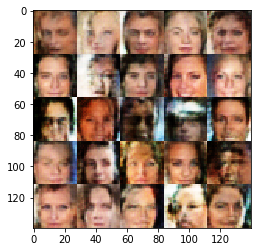

Epoch: 0/1      Batch: 1460      Discriminator Loss: 1.4998      Generator Loss: 0.4917     
Epoch: 0/1      Batch: 1470      Discriminator Loss: 1.6048      Generator Loss: 0.4048     
Epoch: 0/1      Batch: 1480      Discriminator Loss: 1.4966      Generator Loss: 0.5265     
Epoch: 0/1      Batch: 1490      Discriminator Loss: 1.4662      Generator Loss: 0.9327     
Epoch: 0/1      Batch: 1500      Discriminator Loss: 1.2605      Generator Loss: 0.7010     


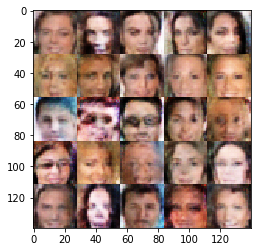

Epoch: 0/1      Batch: 1510      Discriminator Loss: 1.6051      Generator Loss: 0.3160     
Epoch: 0/1      Batch: 1520      Discriminator Loss: 1.5976      Generator Loss: 0.3946     
Epoch: 0/1      Batch: 1530      Discriminator Loss: 1.4870      Generator Loss: 0.4857     
Epoch: 0/1      Batch: 1540      Discriminator Loss: 1.2448      Generator Loss: 1.5238     
Epoch: 0/1      Batch: 1550      Discriminator Loss: 1.4931      Generator Loss: 0.4663     


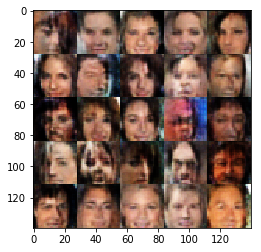

Epoch: 0/1      Batch: 1560      Discriminator Loss: 1.4691      Generator Loss: 0.4661     
Epoch: 0/1      Batch: 1570      Discriminator Loss: 1.5278      Generator Loss: 0.4713     
Epoch: 0/1      Batch: 1580      Discriminator Loss: 1.9423      Generator Loss: 0.2102     
Epoch: 0/1      Batch: 1590      Discriminator Loss: 1.5922      Generator Loss: 0.3849     
Epoch: 0/1      Batch: 1600      Discriminator Loss: 1.4369      Generator Loss: 0.6020     


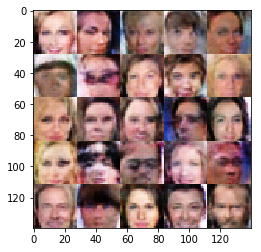

Epoch: 0/1      Batch: 1610      Discriminator Loss: 1.7043      Generator Loss: 0.3363     
Epoch: 0/1      Batch: 1620      Discriminator Loss: 1.5848      Generator Loss: 0.3790     
Epoch: 0/1      Batch: 1630      Discriminator Loss: 1.5197      Generator Loss: 0.5977     
Epoch: 0/1      Batch: 1640      Discriminator Loss: 1.5518      Generator Loss: 0.4425     
Epoch: 0/1      Batch: 1650      Discriminator Loss: 1.6886      Generator Loss: 0.3266     


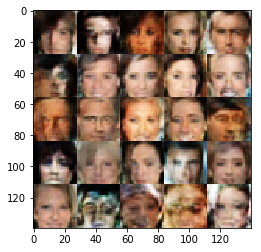

Epoch: 0/1      Batch: 1660      Discriminator Loss: 1.5846      Generator Loss: 0.4194     
Epoch: 0/1      Batch: 1670      Discriminator Loss: 1.5043      Generator Loss: 0.5354     
Epoch: 0/1      Batch: 1680      Discriminator Loss: 1.6325      Generator Loss: 0.4125     
Epoch: 0/1      Batch: 1690      Discriminator Loss: 1.4794      Generator Loss: 0.4996     
Epoch: 0/1      Batch: 1700      Discriminator Loss: 1.5216      Generator Loss: 0.6259     


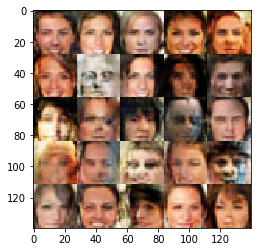

Epoch: 0/1      Batch: 1710      Discriminator Loss: 1.7416      Generator Loss: 0.3116     
Epoch: 0/1      Batch: 1720      Discriminator Loss: 1.3929      Generator Loss: 0.7026     
Epoch: 0/1      Batch: 1730      Discriminator Loss: 1.7932      Generator Loss: 0.6380     
Epoch: 0/1      Batch: 1740      Discriminator Loss: 1.9363      Generator Loss: 0.2480     
Epoch: 0/1      Batch: 1750      Discriminator Loss: 1.5771      Generator Loss: 0.4646     


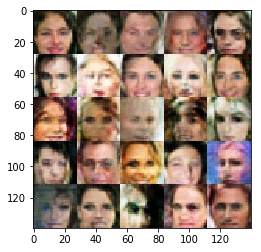

Epoch: 0/1      Batch: 1760      Discriminator Loss: 1.6016      Generator Loss: 0.4135     
Epoch: 0/1      Batch: 1770      Discriminator Loss: 1.5710      Generator Loss: 0.4018     
Epoch: 0/1      Batch: 1780      Discriminator Loss: 1.4856      Generator Loss: 0.5570     
Epoch: 0/1      Batch: 1790      Discriminator Loss: 1.6709      Generator Loss: 0.3941     
Epoch: 0/1      Batch: 1800      Discriminator Loss: 1.5989      Generator Loss: 0.5051     


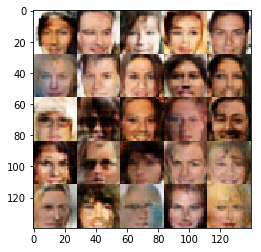

Epoch: 0/1      Batch: 1810      Discriminator Loss: 1.6532      Generator Loss: 0.3831     
Epoch: 0/1      Batch: 1820      Discriminator Loss: 1.5434      Generator Loss: 0.5055     
Epoch: 0/1      Batch: 1830      Discriminator Loss: 1.8489      Generator Loss: 0.2543     
Epoch: 0/1      Batch: 1840      Discriminator Loss: 1.6465      Generator Loss: 0.7111     
Epoch: 0/1      Batch: 1850      Discriminator Loss: 1.6068      Generator Loss: 0.3570     


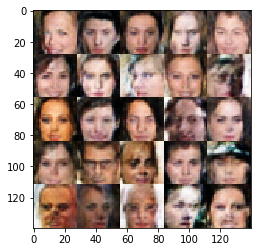

Epoch: 0/1      Batch: 1860      Discriminator Loss: 1.8206      Generator Loss: 0.3341     
Epoch: 0/1      Batch: 1870      Discriminator Loss: 1.9183      Generator Loss: 0.4577     
Epoch: 0/1      Batch: 1880      Discriminator Loss: 1.7256      Generator Loss: 0.3192     
Epoch: 0/1      Batch: 1890      Discriminator Loss: 1.5557      Generator Loss: 0.4701     
Epoch: 0/1      Batch: 1900      Discriminator Loss: 1.6693      Generator Loss: 0.3492     


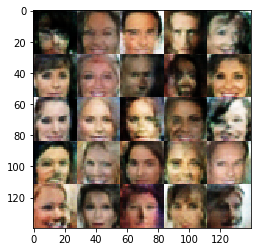

Epoch: 0/1      Batch: 1910      Discriminator Loss: 1.6540      Generator Loss: 0.3616     
Epoch: 0/1      Batch: 1920      Discriminator Loss: 1.4761      Generator Loss: 0.4802     
Epoch: 0/1      Batch: 1930      Discriminator Loss: 1.5762      Generator Loss: 0.6243     
Epoch: 0/1      Batch: 1940      Discriminator Loss: 1.7821      Generator Loss: 0.3140     
Epoch: 0/1      Batch: 1950      Discriminator Loss: 1.6991      Generator Loss: 0.3413     


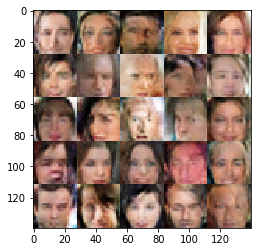

Epoch: 0/1      Batch: 1960      Discriminator Loss: 1.4122      Generator Loss: 0.5675     
Epoch: 0/1      Batch: 1970      Discriminator Loss: 1.6251      Generator Loss: 0.4788     
Epoch: 0/1      Batch: 1980      Discriminator Loss: 1.7006      Generator Loss: 0.3990     
Epoch: 0/1      Batch: 1990      Discriminator Loss: 1.8463      Generator Loss: 0.2263     
Epoch: 0/1      Batch: 2000      Discriminator Loss: 1.6017      Generator Loss: 0.4458     


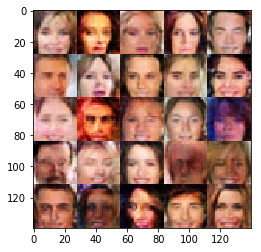

Epoch: 0/1      Batch: 2010      Discriminator Loss: 1.8652      Generator Loss: 0.3131     
Epoch: 0/1      Batch: 2020      Discriminator Loss: 1.4891      Generator Loss: 0.5422     
Epoch: 0/1      Batch: 2030      Discriminator Loss: 1.8603      Generator Loss: 0.5698     
Epoch: 0/1      Batch: 2040      Discriminator Loss: 1.8152      Generator Loss: 0.3323     
Epoch: 0/1      Batch: 2050      Discriminator Loss: 1.5758      Generator Loss: 0.4236     


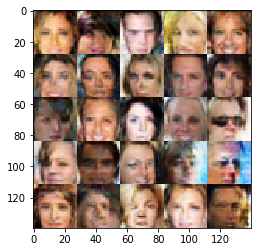

Epoch: 0/1      Batch: 2060      Discriminator Loss: 1.6743      Generator Loss: 0.4899     
Epoch: 0/1      Batch: 2070      Discriminator Loss: 1.4703      Generator Loss: 0.5826     
Epoch: 0/1      Batch: 2080      Discriminator Loss: 1.6344      Generator Loss: 0.3722     
Epoch: 0/1      Batch: 2090      Discriminator Loss: 1.6171      Generator Loss: 0.4664     
Epoch: 0/1      Batch: 2100      Discriminator Loss: 1.4164      Generator Loss: 0.5582     


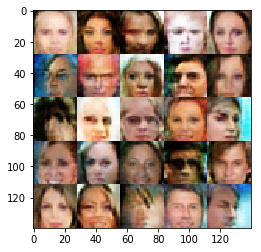

Epoch: 0/1      Batch: 2110      Discriminator Loss: 1.8951      Generator Loss: 0.3030     
Epoch: 0/1      Batch: 2120      Discriminator Loss: 1.6490      Generator Loss: 0.4835     
Epoch: 0/1      Batch: 2130      Discriminator Loss: 1.6401      Generator Loss: 0.3845     
Epoch: 0/1      Batch: 2140      Discriminator Loss: 1.8567      Generator Loss: 0.2784     
Epoch: 0/1      Batch: 2150      Discriminator Loss: 1.7791      Generator Loss: 0.3198     


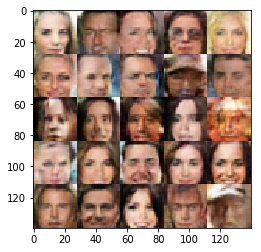

Epoch: 0/1      Batch: 2160      Discriminator Loss: 1.6758      Generator Loss: 0.3062     
Epoch: 0/1      Batch: 2170      Discriminator Loss: 1.5220      Generator Loss: 0.6201     
Epoch: 0/1      Batch: 2180      Discriminator Loss: 1.8166      Generator Loss: 0.3685     
Epoch: 0/1      Batch: 2190      Discriminator Loss: 1.6229      Generator Loss: 0.4025     
Epoch: 0/1      Batch: 2200      Discriminator Loss: 1.5996      Generator Loss: 0.4289     


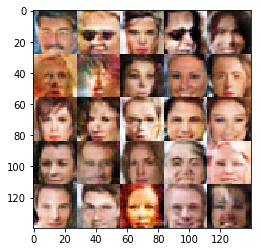

Epoch: 0/1      Batch: 2210      Discriminator Loss: 1.6929      Generator Loss: 0.3712     
Epoch: 0/1      Batch: 2220      Discriminator Loss: 1.5702      Generator Loss: 0.4295     
Epoch: 0/1      Batch: 2230      Discriminator Loss: 1.7307      Generator Loss: 0.3134     
Epoch: 0/1      Batch: 2240      Discriminator Loss: 1.7695      Generator Loss: 0.3208     
Epoch: 0/1      Batch: 2250      Discriminator Loss: 1.6122      Generator Loss: 0.3564     


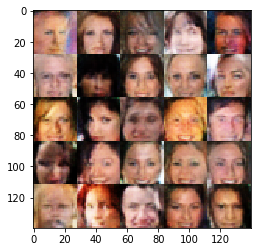

Epoch: 0/1      Batch: 2260      Discriminator Loss: 1.5624      Generator Loss: 0.4165     
Epoch: 0/1      Batch: 2270      Discriminator Loss: 1.8468      Generator Loss: 0.2857     
Epoch: 0/1      Batch: 2280      Discriminator Loss: 1.4962      Generator Loss: 0.7916     
Epoch: 0/1      Batch: 2290      Discriminator Loss: 1.5423      Generator Loss: 0.5169     
Epoch: 0/1      Batch: 2300      Discriminator Loss: 1.5054      Generator Loss: 0.4161     


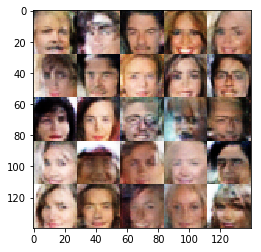

Epoch: 0/1      Batch: 2310      Discriminator Loss: 1.9564      Generator Loss: 0.2433     
Epoch: 0/1      Batch: 2320      Discriminator Loss: 2.1530      Generator Loss: 0.1872     
Epoch: 0/1      Batch: 2330      Discriminator Loss: 1.9334      Generator Loss: 0.2281     
Epoch: 0/1      Batch: 2340      Discriminator Loss: 1.5735      Generator Loss: 0.4437     
Epoch: 0/1      Batch: 2350      Discriminator Loss: 1.6744      Generator Loss: 0.4535     


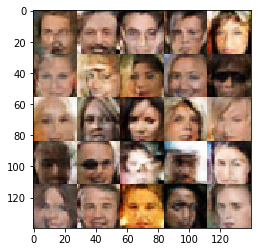

Epoch: 0/1      Batch: 2360      Discriminator Loss: 1.6425      Generator Loss: 0.4874     
Epoch: 0/1      Batch: 2370      Discriminator Loss: 1.7670      Generator Loss: 0.2965     
Epoch: 0/1      Batch: 2380      Discriminator Loss: 1.7523      Generator Loss: 0.4017     
Epoch: 0/1      Batch: 2390      Discriminator Loss: 1.9604      Generator Loss: 0.2221     
Epoch: 0/1      Batch: 2400      Discriminator Loss: 1.5221      Generator Loss: 0.5154     


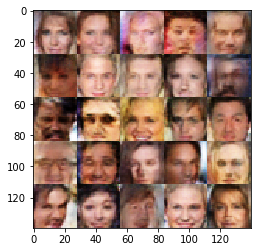

Epoch: 0/1      Batch: 2410      Discriminator Loss: 1.6458      Generator Loss: 0.3515     
Epoch: 0/1      Batch: 2420      Discriminator Loss: 1.8333      Generator Loss: 0.2732     
Epoch: 0/1      Batch: 2430      Discriminator Loss: 1.7569      Generator Loss: 0.2699     
Epoch: 0/1      Batch: 2440      Discriminator Loss: 1.7193      Generator Loss: 0.3442     
Epoch: 0/1      Batch: 2450      Discriminator Loss: 1.4975      Generator Loss: 0.6545     


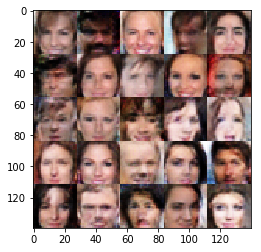

Epoch: 0/1      Batch: 2460      Discriminator Loss: 1.9251      Generator Loss: 0.2538     
Epoch: 0/1      Batch: 2470      Discriminator Loss: 1.7878      Generator Loss: 0.2638     
Epoch: 0/1      Batch: 2480      Discriminator Loss: 1.5937      Generator Loss: 0.3750     
Epoch: 0/1      Batch: 2490      Discriminator Loss: 1.5516      Generator Loss: 0.6567     
Epoch: 0/1      Batch: 2500      Discriminator Loss: 1.5689      Generator Loss: 0.4656     


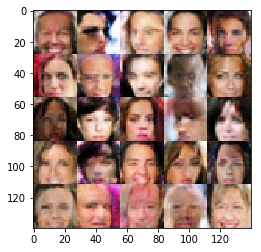

Epoch: 0/1      Batch: 2510      Discriminator Loss: 1.8233      Generator Loss: 0.3511     
Epoch: 0/1      Batch: 2520      Discriminator Loss: 1.5734      Generator Loss: 0.3893     
Epoch: 0/1      Batch: 2530      Discriminator Loss: 1.6853      Generator Loss: 0.3839     
Epoch: 0/1      Batch: 2540      Discriminator Loss: 1.8088      Generator Loss: 0.4091     
Epoch: 0/1      Batch: 2550      Discriminator Loss: 1.5758      Generator Loss: 0.4475     


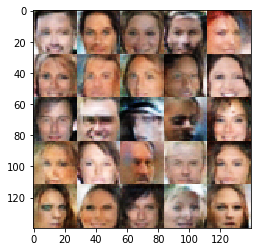

Epoch: 0/1      Batch: 2560      Discriminator Loss: 1.6302      Generator Loss: 0.3597     
Epoch: 0/1      Batch: 2570      Discriminator Loss: 1.7651      Generator Loss: 0.3214     
Epoch: 0/1      Batch: 2580      Discriminator Loss: 1.7681      Generator Loss: 0.2977     
Epoch: 0/1      Batch: 2590      Discriminator Loss: 1.7726      Generator Loss: 0.3943     
Epoch: 0/1      Batch: 2600      Discriminator Loss: 1.5571      Generator Loss: 0.4264     


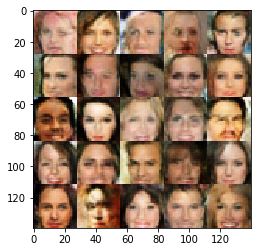

Epoch: 0/1      Batch: 2610      Discriminator Loss: 1.9581      Generator Loss: 0.2489     
Epoch: 0/1      Batch: 2620      Discriminator Loss: 1.7581      Generator Loss: 0.3367     
Epoch: 0/1      Batch: 2630      Discriminator Loss: 1.8657      Generator Loss: 0.2821     
Epoch: 0/1      Batch: 2640      Discriminator Loss: 1.6990      Generator Loss: 0.4211     
Epoch: 0/1      Batch: 2650      Discriminator Loss: 1.5626      Generator Loss: 0.4742     


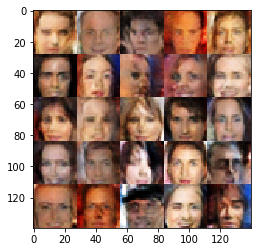

Epoch: 0/1      Batch: 2660      Discriminator Loss: 1.4740      Generator Loss: 0.4600     
Epoch: 0/1      Batch: 2670      Discriminator Loss: 1.7594      Generator Loss: 0.3934     
Epoch: 0/1      Batch: 2680      Discriminator Loss: 1.7884      Generator Loss: 0.3557     
Epoch: 0/1      Batch: 2690      Discriminator Loss: 1.7257      Generator Loss: 0.2924     
Epoch: 0/1      Batch: 2700      Discriminator Loss: 1.5505      Generator Loss: 0.7940     


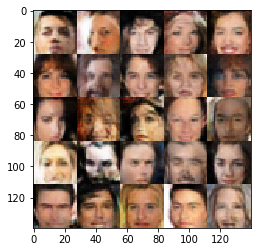

Epoch: 0/1      Batch: 2710      Discriminator Loss: 1.7105      Generator Loss: 0.3649     
Epoch: 0/1      Batch: 2720      Discriminator Loss: 1.5459      Generator Loss: 0.4090     
Epoch: 0/1      Batch: 2730      Discriminator Loss: 1.3644      Generator Loss: 0.7262     
Epoch: 0/1      Batch: 2740      Discriminator Loss: 1.8424      Generator Loss: 0.3014     
Epoch: 0/1      Batch: 2750      Discriminator Loss: 1.3383      Generator Loss: 0.9370     


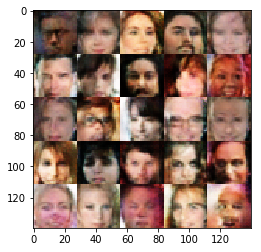

Epoch: 0/1      Batch: 2760      Discriminator Loss: 1.6760      Generator Loss: 0.3469     
Epoch: 0/1      Batch: 2770      Discriminator Loss: 1.8331      Generator Loss: 0.2853     
Epoch: 0/1      Batch: 2780      Discriminator Loss: 1.5407      Generator Loss: 0.5212     
Epoch: 0/1      Batch: 2790      Discriminator Loss: 1.8396      Generator Loss: 0.2706     
Epoch: 0/1      Batch: 2800      Discriminator Loss: 1.5554      Generator Loss: 0.4280     


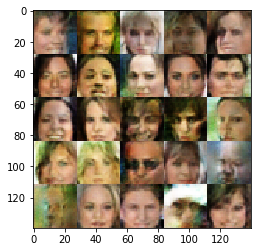

Epoch: 0/1      Batch: 2810      Discriminator Loss: 1.6483      Generator Loss: 0.4241     
Epoch: 0/1      Batch: 2820      Discriminator Loss: 2.0585      Generator Loss: 0.2627     
Epoch: 0/1      Batch: 2830      Discriminator Loss: 1.7495      Generator Loss: 0.4053     
Epoch: 0/1      Batch: 2840      Discriminator Loss: 1.8226      Generator Loss: 0.3648     
Epoch: 0/1      Batch: 2850      Discriminator Loss: 1.8466      Generator Loss: 0.3014     


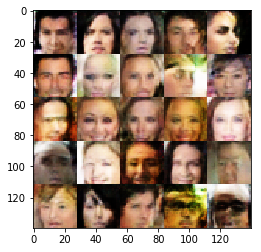

Epoch: 0/1      Batch: 2860      Discriminator Loss: 1.7213      Generator Loss: 0.2816     
Epoch: 0/1      Batch: 2870      Discriminator Loss: 1.8589      Generator Loss: 0.2959     
Epoch: 0/1      Batch: 2880      Discriminator Loss: 2.0585      Generator Loss: 0.3055     
Epoch: 0/1      Batch: 2890      Discriminator Loss: 1.7388      Generator Loss: 0.3568     
Epoch: 0/1      Batch: 2900      Discriminator Loss: 1.9670      Generator Loss: 0.2411     


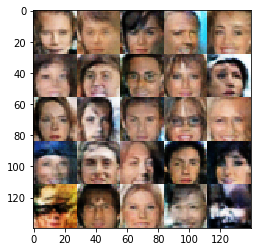

Epoch: 0/1      Batch: 2910      Discriminator Loss: 1.9049      Generator Loss: 0.2902     
Epoch: 0/1      Batch: 2920      Discriminator Loss: 1.6735      Generator Loss: 0.6436     
Epoch: 0/1      Batch: 2930      Discriminator Loss: 1.7882      Generator Loss: 0.2882     
Epoch: 0/1      Batch: 2940      Discriminator Loss: 1.7330      Generator Loss: 0.2865     
Epoch: 0/1      Batch: 2950      Discriminator Loss: 1.7634      Generator Loss: 0.3956     


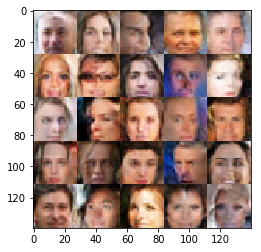

Epoch: 0/1      Batch: 2960      Discriminator Loss: 2.0824      Generator Loss: 0.2537     
Epoch: 0/1      Batch: 2970      Discriminator Loss: 1.7486      Generator Loss: 0.5511     
Epoch: 0/1      Batch: 2980      Discriminator Loss: 1.6742      Generator Loss: 0.3716     
Epoch: 0/1      Batch: 2990      Discriminator Loss: 1.9827      Generator Loss: 0.2016     
Epoch: 0/1      Batch: 3000      Discriminator Loss: 1.6674      Generator Loss: 0.5196     


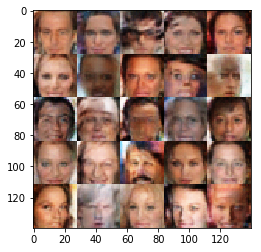

Epoch: 0/1      Batch: 3010      Discriminator Loss: 1.6228      Generator Loss: 0.3277     
Epoch: 0/1      Batch: 3020      Discriminator Loss: 1.7378      Generator Loss: 0.3175     
Epoch: 0/1      Batch: 3030      Discriminator Loss: 1.7904      Generator Loss: 0.2575     
Epoch: 0/1      Batch: 3040      Discriminator Loss: 1.6801      Generator Loss: 0.5132     
Epoch: 0/1      Batch: 3050      Discriminator Loss: 1.6610      Generator Loss: 0.5739     


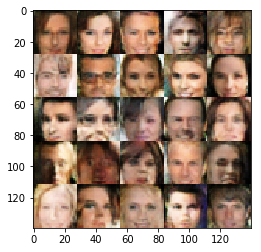

Epoch: 0/1      Batch: 3060      Discriminator Loss: 1.5152      Generator Loss: 0.4444     
Epoch: 0/1      Batch: 3070      Discriminator Loss: 1.6561      Generator Loss: 0.4595     
Epoch: 0/1      Batch: 3080      Discriminator Loss: 1.5862      Generator Loss: 0.5003     
Epoch: 0/1      Batch: 3090      Discriminator Loss: 1.8780      Generator Loss: 0.2570     
Epoch: 0/1      Batch: 3100      Discriminator Loss: 1.8463      Generator Loss: 0.3146     


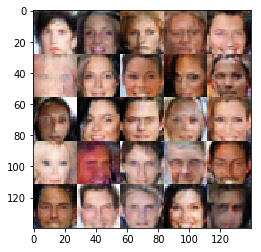

Epoch: 0/1      Batch: 3110      Discriminator Loss: 1.7552      Generator Loss: 0.3033     
Epoch: 0/1      Batch: 3120      Discriminator Loss: 1.7857      Generator Loss: 0.4010     
Epoch: 0/1      Batch: 3130      Discriminator Loss: 1.5356      Generator Loss: 0.4525     
Epoch: 0/1      Batch: 3140      Discriminator Loss: 1.6604      Generator Loss: 0.4251     
Epoch: 0/1      Batch: 3150      Discriminator Loss: 1.8983      Generator Loss: 0.2529     


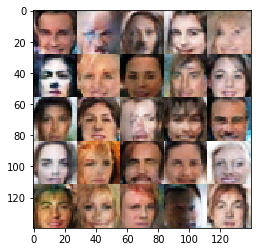

Epoch: 0/1      Batch: 3160      Discriminator Loss: 1.7440      Generator Loss: 0.2932     


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.